In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

100%|██████████| 172k/172k [00:00<00:00, 59.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [3]:
import pandas as pd
import numpy as np

# Load the dataset
dataset_path = "/root/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1/WA_Fn-UseC_-Telco-Customer-Churn.csv"
dataset = pd.read_csv(dataset_path)
dataset.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# 删除 customerID 列，因为它不会对流失预测产生影响
dataset = dataset.drop(columns=["customerID"])

# 将 TotalCharges 列转换为数值（因为可能有空值）
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

# 检查并填充 TotalCharges 的缺失值
dataset['TotalCharges'] = dataset['TotalCharges'].fillna(dataset['TotalCharges'].mean())

# 将类别变量转换为数值变量
from sklearn.preprocessing import LabelEncoder

# 初始化 LabelEncoder
label_encoder = LabelEncoder()

# 对每个对象类型的列进行编码
for column in dataset.select_dtypes(include=["object"]).columns:
    dataset[column] = label_encoder.fit_transform(dataset[column])

print(dataset.head())


   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1                 

In [5]:
# 检查缺失值
print(dataset.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


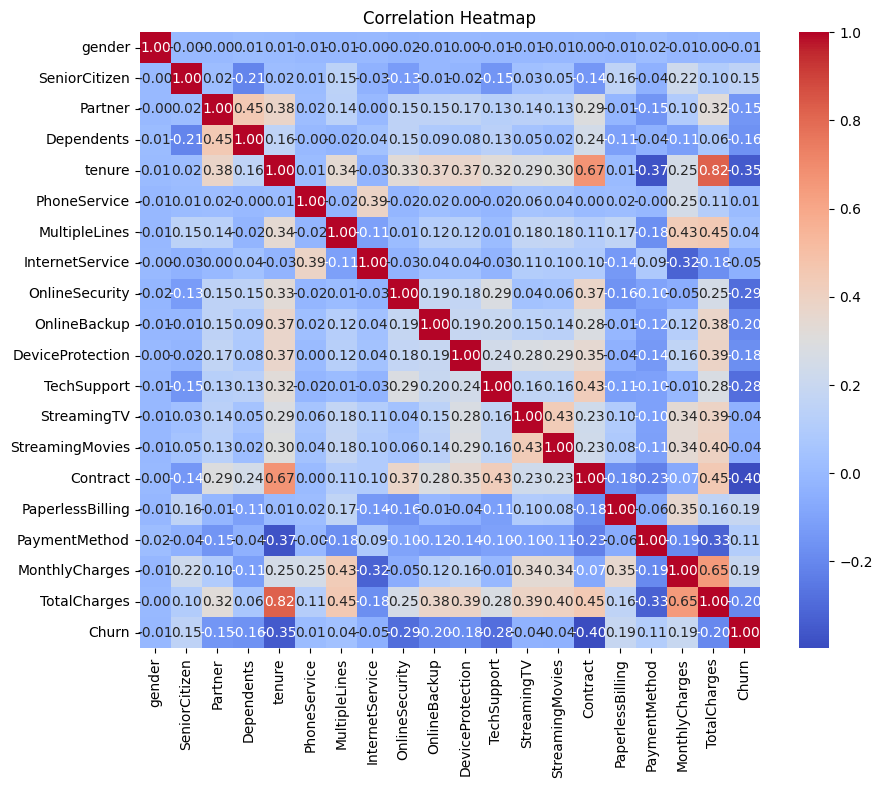

In [6]:
# 特征相关性热图
import seaborn as sns
import matplotlib.pyplot as plt

# 计算数值特征的相关性矩阵
correlation_matrix = dataset.corr()

# 绘制相关性热图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()


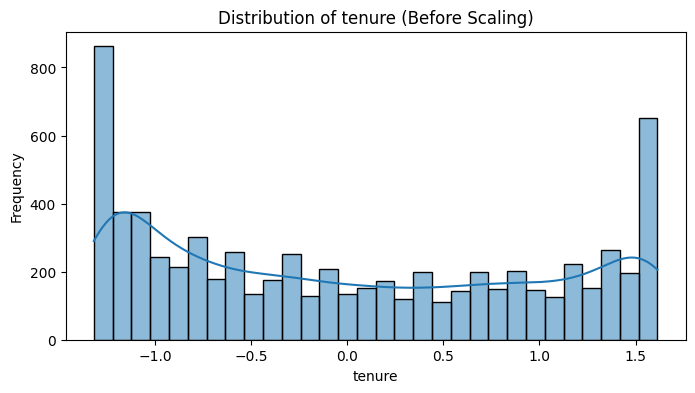

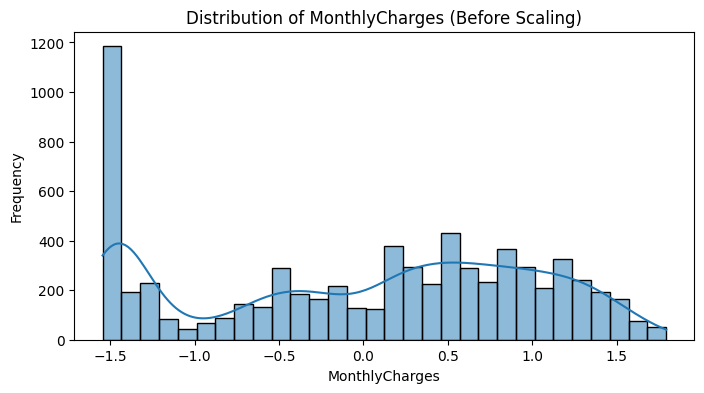

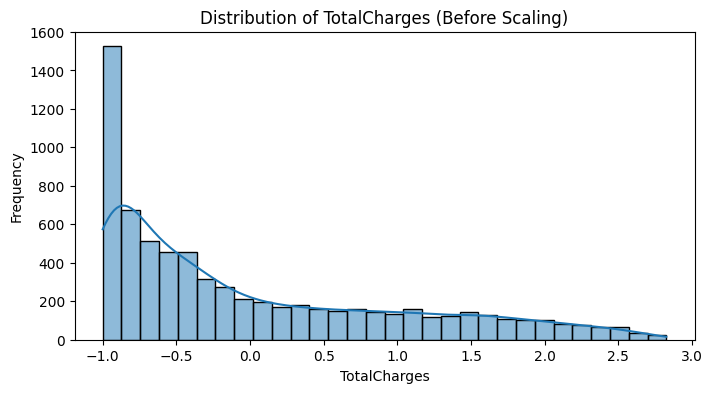

   gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       0              0        1           0 -1.277445             0   
1       1              0        0           0  0.066327             1   
2       1              0        0           0 -1.236724             1   
3       1              0        0           0  0.514251             0   
4       0              0        0           0 -1.236724             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1     

In [7]:
from sklearn.preprocessing import StandardScaler

# 初始化标准化器
scaler = StandardScaler()

# 标准化所有数值列
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
dataset[numeric_columns] = scaler.fit_transform(dataset[numeric_columns])

for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(dataset[column], kde=True, bins=30)
    plt.title(f"Distribution of {column} (Before Scaling)")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

print(dataset.head())


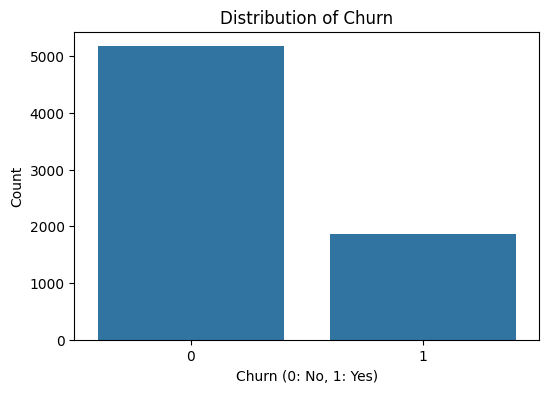

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [8]:
# 检查目标列的类别分布
# 绘制类别分布条形图
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=dataset)
plt.title("Distribution of Churn")
plt.xlabel("Churn (0: No, 1: Yes)")
plt.ylabel("Count")
plt.show()

print(dataset['Churn'].value_counts(normalize=True))

In [9]:
# SMOTE Oversampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# 特征和目标变量
X = dataset.drop(columns=['Churn'])
y = dataset['Churn']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用 SMOTE 进行过采样
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


# 检查新的类别分布
print("原始类别分布:")
print(y_train.value_counts())
print("\n过采样后类别分布:")
print(pd.Series(y_resampled).value_counts())


原始类别分布:
Churn
0    4138
1    1496
Name: count, dtype: int64

过采样后类别分布:
Churn
0    4138
1    4138
Name: count, dtype: int64


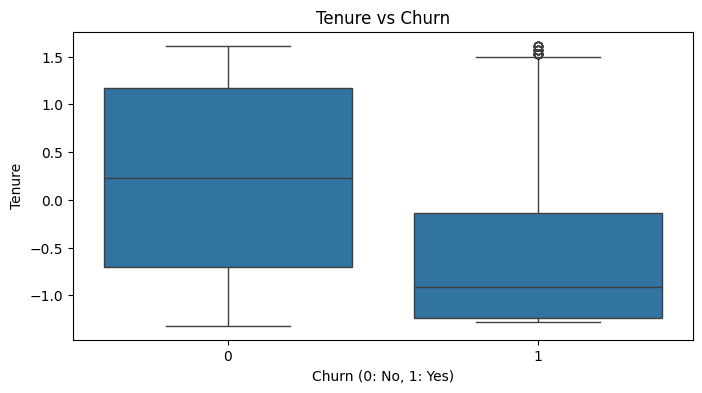

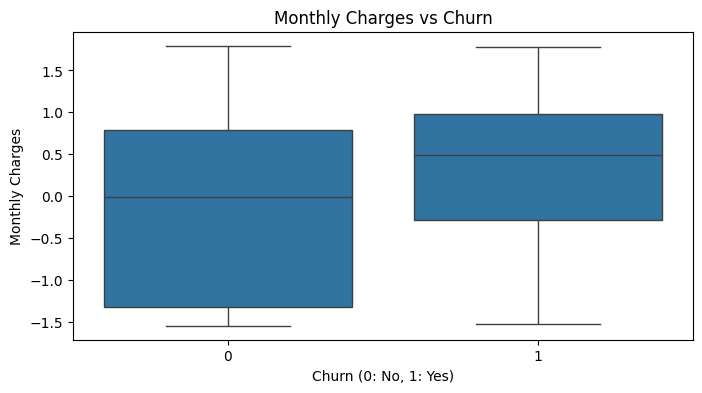

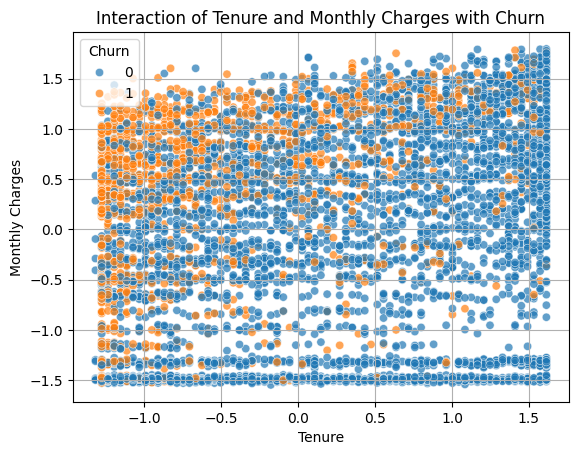

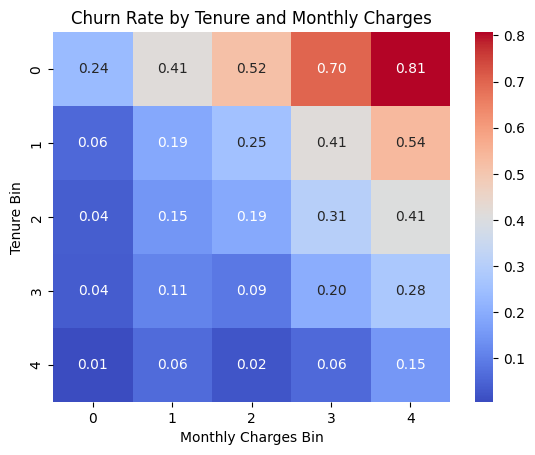

训练集样本数: (8276, 19)
测试集样本数: (1409, 19)


In [10]:


# # 特征列和目标列
# X = dataset.drop(columns=["Churn"])
# y = dataset["Churn"]

# tenure 和 Churn 的关系
plt.figure(figsize=(8, 4))
sns.boxplot(x='Churn', y='tenure', data=dataset)
plt.title("Tenure vs Churn")
plt.xlabel("Churn (0: No, 1: Yes)")
plt.ylabel("Tenure")
plt.show()

# MonthlyCharges 和 Churn 的关系
plt.figure(figsize=(8, 4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=dataset)
plt.title("Monthly Charges vs Churn")
plt.xlabel("Churn (0: No, 1: Yes)")
plt.ylabel("Monthly Charges")
plt.show()

# 绘制交互作用图
sns.scatterplot(data=dataset, x="tenure", y="MonthlyCharges", hue="Churn", alpha=0.7)
plt.title("Interaction of Tenure and Monthly Charges with Churn")
plt.xlabel("Tenure")
plt.ylabel("Monthly Charges")
plt.legend(title="Churn")
plt.grid()
plt.show()

# 将 Tenure 和 MonthlyCharges 分箱
dataset['Tenure_bin'] = pd.cut(dataset['tenure'], bins=5, labels=False)
dataset['MonthlyCharges_bin'] = pd.cut(dataset['MonthlyCharges'], bins=5, labels=False)

# 计算每个区间的流失率
churn_rate_by_bin = dataset.groupby(['Tenure_bin', 'MonthlyCharges_bin'])['Churn'].mean().unstack()
sns.heatmap(churn_rate_by_bin, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Churn Rate by Tenure and Monthly Charges")
plt.xlabel("Monthly Charges Bin")
plt.ylabel("Tenure Bin")
plt.show()

# # 划分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, y_train = X_resampled, y_resampled

print("训练集样本数:", X_train.shape)
print("测试集样本数:", X_test.shape)


1. 第一张图: Tenure vs Churn
图解：

Tenure（客户在网时间）的分布在流失客户（Churn=1）和未流失客户（Churn=0）之间有明显差异。
未流失客户的 Tenure 更高，分布集中在中高区间，表明长期客户流失的概率较低。
流失客户的 Tenure 较低，说明新客户（或短期用户）更容易流失。
结论：

Tenure 是客户流失的一个重要指标。
长期用户可能与服务建立了更稳定的关系，因此流失率较低，而短期用户可能对服务的满意度不高或还未建立足够的黏性。
2. 第二张图: Monthly Charges vs Churn
图解：

MonthlyCharges（月度消费金额）的分布在流失客户和未流失客户之间也有差异。
流失客户的 MonthlyCharges 中位数较高，并且分布整体偏向更高的消费区间。
未流失客户的 MonthlyCharges 分布相对较低，且更平均。
结论：

MonthlyCharges 是另一个可能影响客户流失的重要因素。
高消费客户更容易流失，这可能与服务定价不合理、性价比不高或客户感知到的价值低相关。
可以得出的关键洞见
短期用户更容易流失：

新用户可能对服务不满意或没有建立品牌忠诚度。
提升新用户的体验（如折扣、新用户福利）可能有助于减少流失。
高消费用户更容易流失：

高消费可能导致用户对性价比的敏感性增加，尤其是如果用户感觉花费过高而没有得到相应的服务价值。
针对高消费用户的个性化优惠或增值服务（如定制方案、会员福利）可能有助于降低流失。

3. 第三张图：Interaction of Tenure and Monthly Charges with Churn 图解：

这张散点图展示了 Tenure 和 Monthly Charges 的关系，并以颜色区分了流失客户（Churn=1）和未流失客户（Churn=0）。
Tenure 和 Monthly Charges 都已经标准化，因此横轴和纵轴的数值范围在标准化后的范围（约 -1.5 到 1.5）之间。
洞见：

流失客户（橙色点）的集中分布：
流失客户主要集中在短期用户（Tenure 低于 0，标准化后对应短期客户）和高消费用户（Monthly Charges 高于 0，标准化后对应高消费）。
这表明短期且高消费的客户更容易流失。
未流失客户（蓝色点）的分布：
未流失客户覆盖整个图表，但集中分布在长期用户（Tenure 高于 0）和低消费用户（Monthly Charges 低于 0）。
这表明长期客户对服务的忠诚度较高，低消费客户可能对价格的敏感性较低。
特征的交互关系：
短期用户的流失率更高，这一趋势在高消费用户中尤为明显。
建议：

针对短期且高消费的用户，设计针对性的策略，例如优惠券或个性化增值服务，减少其流失可能性。
增强短期用户的体验，尤其是在服务初期提供引导和支持，帮助建立品牌忠诚度。
4. 第四张图：Churn Rate by Tenure and Monthly Charges （热力图）图解:

这张热力图将 Tenure 和 Monthly Charges 分箱，并显示每个区间的流失率（以颜色表示，红色表示流失率高，蓝色表示流失率低）。
洞见：

高流失率区域：
在短期用户（Tenure Bin = 0 和 1）中，高消费用户（Monthly Charges Bin = 3 和 4）显示出较高的流失率，流失率最高可达 81%。
短期用户和高消费用户的组合是主要的流失风险区域。
低流失率区域：
在长期用户（Tenure Bin = 4）中，无论消费水平如何，流失率都很低（最低 1%）。
说明长期客户对服务更满意或已经建立了较高的忠诚度。
消费区间的影响：
高消费（Monthly Charges Bin = 4）显著增加了短期客户的流失风险，而低消费（Monthly Charges Bin = 0 和 1）对应的流失率相对较低。
建议：

针对短期且高消费用户设计挽留策略：
提供个性化折扣或服务（例如：订阅折扣、限时优惠）。
增强客户体验（如客户支持、个性化推荐）。
加强对短期用户的关注：
例如，在服务的早期阶段提供更好的引导和服务说明，以帮助他们快速适应服务。
保持长期客户的忠诚度：
可以通过会员福利或长期客户折扣加强对长期用户的奖励。
综合洞见
短期用户和高消费用户的流失风险较高：

这是主要的流失风险人群，需要重点关注。
增加价值感（如增强服务、提供折扣）可能有助于降低这一群体的流失率。
长期用户更稳定：

长期用户对服务的忠诚度更高，他们的流失率普遍较低。
维护长期用户的满意度对于减少整体流失率非常重要。
特征的交互关系：

单独分析 Tenure 或 Monthly Charges 都能显示流失趋势，但两者的交互（短期且高消费）揭示了更高的风险。


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 初始化逻辑回归模型
model = LogisticRegression()

# 训练模型
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_train)

# 输出分类报告和准确率
print("训练集分类报告:\n", classification_report(y_train, y_pred))
print("准确率:", accuracy_score(y_train, y_pred))

y_pred = model.predict(X_test)

# 输出分类报告和准确率
print("测试集分类报告:\n", classification_report(y_test, y_pred))
print("准确率:", accuracy_score(y_test, y_pred))


训练集分类报告:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77      4138
           1       0.75      0.83      0.79      4138

    accuracy                           0.78      8276
   macro avg       0.78      0.78      0.78      8276
weighted avg       0.78      0.78      0.78      8276

准确率: 0.777791203479942
测试集分类报告:
               precision    recall  f1-score   support

           0       0.92      0.72      0.81      1036
           1       0.52      0.84      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.72      1409
weighted avg       0.82      0.75      0.76      1409

准确率: 0.7501774308019872


AUC 值: 0.8504727918266793


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


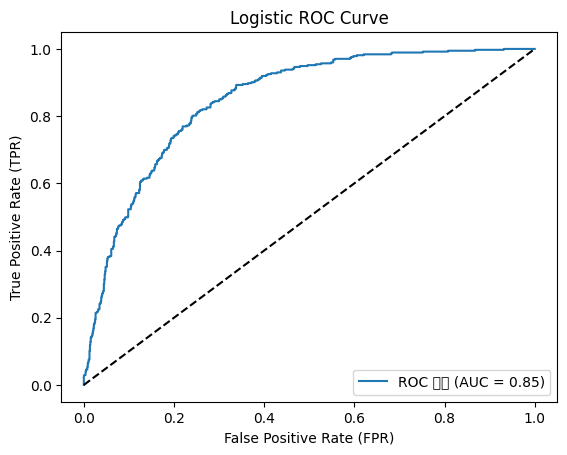

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 计算 ROC 曲线
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 计算 AUC 值
auc = roc_auc_score(y_test, y_proba)
print("AUC 值:", auc)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label=f"ROC 曲线 (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # 随机分类的参考线
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Logistic ROC Curve")
plt.legend(loc="lower right")
plt.show()


分类报告 (随机森林):
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      4138
           1       0.94      0.97      0.96      4138

    accuracy                           0.96      8276
   macro avg       0.96      0.96      0.96      8276
weighted avg       0.96      0.96      0.96      8276

准确率 (随机森林): 0.9577090381826969
分类报告 (随机森林):
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      1036
           1       0.57      0.73      0.64       373

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.81      0.78      0.79      1409

准确率 (随机森林): 0.7814052519517388


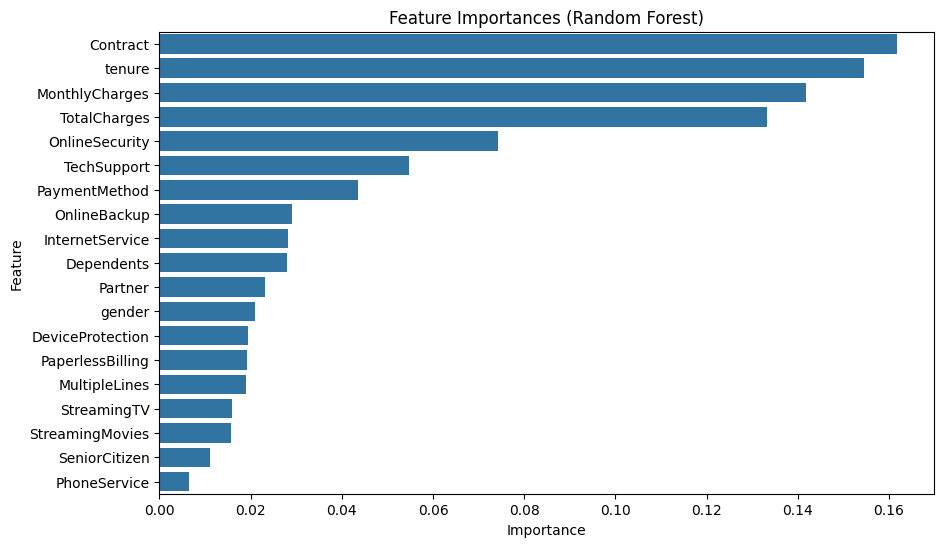

交叉验证准确率: [0.74154589 0.75589124 0.7836858  0.79093656 0.79577039]
交叉验证平均准确率: 0.7735659763270429


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# 初始化随机森林
# rf_model = RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)
# rf_model = RandomForestClassifier(random_state=42)
# rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(max_depth=20, random_state=42,  min_samples_leaf=2, n_estimators=200)
# rf_model = RandomForestClassifier()

# 训练随机森林模型
rf_model.fit(X_train, y_train)


# 预测
rf_y_pred = rf_model.predict(X_train)

# 输出分类报告和准确率
print("分类报告 (随机森林):\n", classification_report(y_train, rf_y_pred))
print("准确率 (随机森林):", accuracy_score(y_train, rf_y_pred))


# 预测
rf_y_pred = rf_model.predict(X_test)

# 输出分类报告和准确率
print("分类报告 (随机森林):\n", classification_report(y_test, rf_y_pred))
print("准确率 (随机森林):", accuracy_score(y_test, rf_y_pred))

# 获取特征重要性
feature_importances = rf_model.feature_importances_
features = X_train.columns

# 将特征重要性排序
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 绘制条形图
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# 通过交叉验证评估性能
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("交叉验证准确率:", scores)
print("交叉验证平均准确率:", scores.mean())



AUC 值: 0.8432825778670283


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


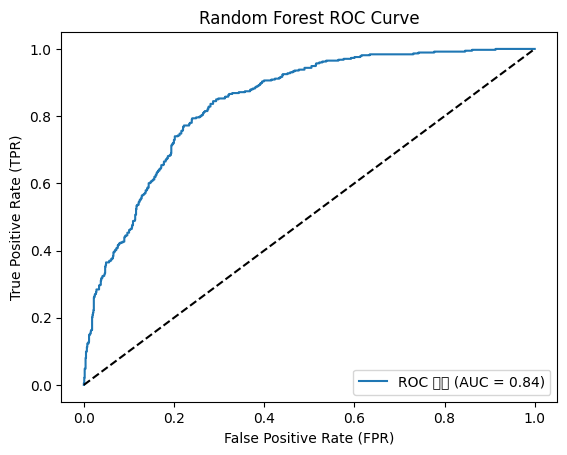

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 计算 ROC 曲线
y_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 计算 AUC 值
auc = roc_auc_score(y_test, y_proba)
print("AUC 值:", auc)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label=f"ROC 曲线 (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # 随机分类的参考线
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter


# 初始化 XGBoost 模型
model = XGBClassifier(
    n_estimators=100,         # 树的数量（默认值）
    max_depth=6,              # 树的最大深度（默认值）
    learning_rate=0.3,        # 学习率（默认值）
    scale_pos_weight=1,       # 类别权重比例，处理不平衡数据时很重要
    random_state=42           # 随机数种子
)

# 训练模型
model.fit(X_train, y_train)

# 在训练集上预测
y_pred_train = model.predict(X_train)

# 输出训练集分类报告和准确率
print("训练集分类报告:\n", classification_report(y_train, y_pred_train))
print("训练集准确率:", accuracy_score(y_train, y_pred_train))

# 在测试集上预测
y_pred_test = model.predict(X_test)

# 输出测试集分类报告和准确率
print("测试集分类报告:\n", classification_report(y_test, y_pred_test))
print("测试集准确率:", accuracy_score(y_test, y_pred_test))

训练集分类报告:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      4138
           1       0.92      0.96      0.94      4138

    accuracy                           0.94      8276
   macro avg       0.94      0.94      0.94      8276
weighted avg       0.94      0.94      0.94      8276

训练集准确率: 0.9397051715804736
测试集分类报告:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1036
           1       0.56      0.67      0.61       373

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.78      1409

测试集准确率: 0.7750177430801988


AUC 值: 0.8267581541710228


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


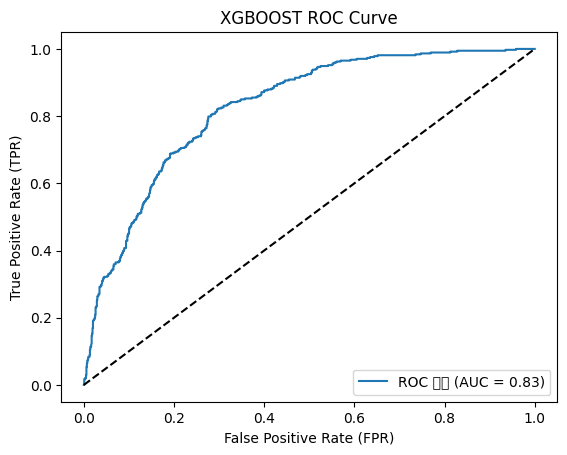

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 计算 ROC 曲线
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 计算 AUC 值
auc = roc_auc_score(y_test, y_proba)
print("AUC 值:", auc)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label=f"ROC 曲线 (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # 随机分类的参考线
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("XGBOOST ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [17]:
from sklearn.ensemble import VotingClassifier

# 定义多个基模型
logistic = LogisticRegression(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
xgb = XGBClassifier(scale_pos_weight=3, random_state=42)

# 创建投票分类器
voting_clf = VotingClassifier(
    estimators=[('lr', logistic), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

# 在训练集上预测
y_pred_train = voting_clf.predict(X_train)

# 输出训练集分类报告和准确率
print("训练集分类报告:\n", classification_report(y_train, y_pred_train))
print("训练集准确率:", accuracy_score(y_train, y_pred_train))

# 在测试集上预测
y_pred_test = voting_clf.predict(X_test)

# 输出测试集分类报告和准确率
print("测试集分类报告:\n", classification_report(y_test, y_pred_test))
print("测试集准确率:", accuracy_score(y_test, y_pred_test))

训练集分类报告:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93      4138
           1       0.89      0.99      0.94      4138

    accuracy                           0.93      8276
   macro avg       0.94      0.93      0.93      8276
weighted avg       0.94      0.93      0.93      8276

训练集准确率: 0.9335427742870952
测试集分类报告:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83      1036
           1       0.54      0.79      0.64       373

    accuracy                           0.77      1409
   macro avg       0.73      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409

测试集准确率: 0.7672107877927609


AUC 值: 0.847507168217624


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


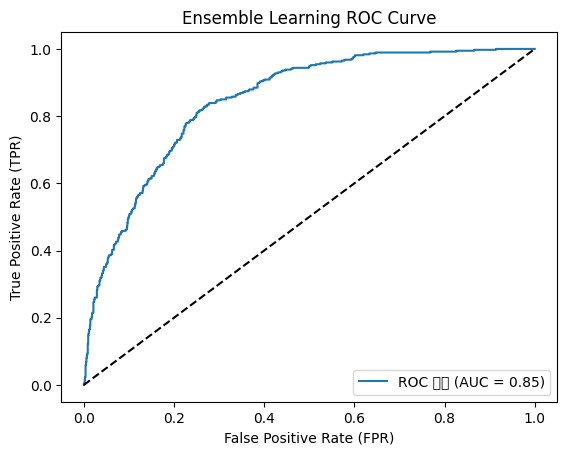

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 计算 ROC 曲线
y_proba = voting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 计算 AUC 值
auc = roc_auc_score(y_test, y_proba)
print("AUC 值:", auc)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label=f"ROC 曲线 (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # 随机分类的参考线
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Ensemble Learning ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [19]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# 网格搜索
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("最优参数:", grid_search.best_params_)
print("最佳准确率:", grid_search.best_score_)


最优参数: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
最佳准确率: 0.8331355496148891


In [ ]:
# import joblib

# # 保存模型
# joblib.dump(rf_model, "customer_churn_model.pkl")

# # 加载模型
# loaded_model = joblib.load("customer_churn_model.pkl")
